# Stochastic Swim Meet Simulator

In this notebook, I attempt to build a probabilistic simulator for the Missouri Boys High School State 2025 Swimming Championships using a **Markov-ish performance state** model & **Monte Carlo** simulation.

Here is my process:
1) Load in CSV data & formatting properly
2) Create variability in every swimmer's performance using a simple Markov performance state
3) Adaptive interdependence, where if one person on the team does good, the rest also do better (team momentum effect)
4) Do the Monte Carlo loop to estimate each team's win probabilities and distributions
5) Integer linear programming to optimize events for swimmer (2 individual events per swimmer, will add relay stuff later)

Summary: (1) Markov chain for each swimmer &rarr; (2) Monte Carlo sampling across many simulated meets &rarr; (3) Resulting outcome distribution


In [22]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import random

import matplotlib.pyplot as plt
import seaborn as sns

## 1) Load & prep data

Input CSV format (downloaded from the MSHSAA website):
- Empty column headers, except for event names
- Then columns have place, time, competitor name, school name which repeats horizontally

Output CSV format:
- `name`: swimmer name
- `team`: school name
- `event`: event name, (relays not done yet)
- `best_time`: best seed time in seconds this season
- `seed_rank`: rank/seed for that event (1 = top seed)

In [23]:
df = pd.read_csv('missouri_swim_data.csv', header=None)

# Extract event names from first row (skip empty columns)
events = []
event_cols = []
for i in range(0, len(df.columns)-1):
    if i < len(df.columns) and pd.notna(df.iloc[0, i+1]):
        event_name = df.iloc[0, i+1]
        events.append(event_name)
        event_cols.append(i)

In [24]:
events

['200 Medley Relay',
 '200 Freestyle',
 '200 Individual Medley',
 '50 Freestyle',
 '100 Butterfly',
 '100 Freestyle',
 '500 Freestyle',
 '200 Freestyle Relay',
 '100 Backstroke',
 '100 Breaststroke',
 '400 Freestyle Relay']

In [25]:
# Initialize list to store all swimmer records
all_records = []

# Process each event
for event_idx, (event_name, col_start) in enumerate(tqdm(zip(events, event_cols), total=len(events), desc="Processing Events")):
    # Determine if this is a relay event (check if there are swimmer names)
    is_relay = 'Relay' in event_name
    
    # Process each row (starting from row 1, skipping header row 0)
    for row_idx in tqdm(range(1, len(df)), leave=False, desc=f"Event {event_name}"):
        rank = df.iloc[row_idx, col_start - 1]
        time = df.iloc[row_idx, col_start]
        name_or_team = df.iloc[row_idx, col_start + 1]
        team = df.iloc[row_idx, col_start + 2] if not is_relay else name_or_team  # For relays, name_or_team is the team name
        
        # Skip if rank or time is missing
        if pd.isna(rank) or pd.isna(time) or pd.isna(name_or_team):
            continue
        
        # Convert time from MM:SS.SS to total seconds
        if isinstance(time, str) and ':' in time:
            parts = time.split(':')
            total_seconds = float(parts[0]) * 60 + float(parts[1])
        else:
            total_seconds = float(time)
        
        # For individual events
        if not is_relay:
            record = {
                'name': name_or_team,
                'team': team,
                'event': event_name,
                'best_time': total_seconds,
                'seed_rank': int(rank),
                'is_relay': False
            }
            all_records.append(record)
        else:
            # For relay events: team-based, not individual swimmer-based
            record = {
                'name': team,  # For relays, 'name' is the team name
                'team': team,
                'event': event_name,
                'best_time': total_seconds,
                'seed_rank': int(rank),
                'is_relay': True
            }
            all_records.append(record)

# Create DataFrame from records
result_df = pd.DataFrame(all_records)

Processing Events: 100%|██████████| 11/11 [00:00<00:00, 92.44it/s]


In [26]:
result_df.sample(5)

,name,team,event,best_time,seed_rank,is_relay
162,Finn Hoffman,Lee's Summit West,200 Freestyle,114.59,80,False
377,Hunter Johnson,Camdenton,200 Individual Medley,136.38,146,False
1042,Davis Foster,Rockhurst,500 Freestyle,332.23,125,False
227,Connor Wiggs,Poplar Bluff,200 Freestyle,120.17,145,False
791,William Steurer,SLUH,100 Freestyle,50.18,49,False


In [27]:
# save results
result_df.to_csv('swimmers.csv', index=False)

In [28]:
# split by class
swimmers = pd.read_csv("swimmers.csv")
schools = pd.read_csv("schools.csv")

# Merge Class info into swimmer table
swimmers = swimmers.merge(
    schools[['School', 'Class']],
    left_on='team',
    right_on='School',
    how='left'
).drop(columns=['School'])

In [29]:
swimmers["best_time"] = pd.to_numeric(swimmers["best_time"], errors="coerce")

# Sort by class, then event, then best_time ascending (faster = smaller time)
swimmers = swimmers.sort_values(["Class", "event", "best_time"], ascending=[True, True, True])

swimmers["old_seed_rank"] = swimmers["seed_rank"]

# Now assign new seed ranks within each class+event group
swimmers["seed_rank"] = (
    swimmers.groupby(["Class", "event"])
    .cumcount() + 1
)

# Save or inspect
swimmers.to_csv("swimmers_reseeded.csv", index=False)

In [30]:
class1_swimmers = swimmers[swimmers['Class'] == 1]
class2_swimmers = swimmers[swimmers['Class'] == 2]

In [31]:
result_df = class1_swimmers

In [32]:
result_df.head(10)

,name,team,event,best_time,seed_rank,is_relay,Class,old_seed_rank
1141,Brody Blatt,Parkway Central,100 Backstroke,50.68,1,False,1,2
1142,Clark Montgomery,Webster Groves,100 Backstroke,51.91,2,False,1,3
1147,Kaiden Cracraft,Notre Dame (Cape Girardeau),100 Backstroke,53.28,3,False,1,8
1148,Burgess Walden,Pembroke Hill,100 Backstroke,54.10,4,False,1,9
1149,Jonathan Grant,Pembroke Hill,100 Backstroke,54.39,5,False,1,10
1150,Mason Wardlow,William Chrisman,100 Backstroke,54.42,6,False,1,11
1152,Cole Strom,Webster Groves,100 Backstroke,54.57,7,False,1,13
1153,Alexander Atkins,Parkway West,100 Backstroke,54.68,8,False,1,14
1155,Calvin Mueller,Hannibal,100 Backstroke,54.89,9,False,1,16
1156,Kolton Evans,Nevada,100 Backstroke,54.99,10,False,1,17


## 2) Performance model (w/ MCMC!)
I model each swimmer's resulting time using Markov Chain Monte Carlo (MCMC). This best simulates how a swimmer might perform at a specific meet because each swimmer has a performance state *(Good / Average / Bad)* and I add noise of +/- 0.5% or ~0.2s to every outcome.

**To explain the Markov Chain part more:** Swimmers move between these states in their events as the simulated swim meet goes on.
| State   | Time Adjustment      |
| ------- | -------------------- |
| Good    | 0.98 × personal best |
| Average | 1.00 × personal best |
| Bad     | 1.03 × personal best |

These are the transition probabilities of moving between states:
| From → To   | Good | Average | Bad |
| ----------- | ---- | ------- | --- |
| **Good**    | 0.7  | 0.2     | 0.1 |
| **Average** | 0.3  | 0.5     | 0.2 |
| **Bad**     | 0.1  | 0.3     | 0.6 |

Ex. If a swimmer is in the Good state right now, they have:
- a 70% chance to stay Good in the next event,
- a 20% chance to slip to Average,
- a 10% chance to have a Bad race.

Note how it's stochastic, meaning that you don't know the exact outcome but you know the distribution. This is to capture the concept of a swimmer having a 'good' or 'bad' day or race and how that affects other events

**To explain the Monte Carlo part more:** each meet = 1 Monte Carlo trial & a swimmer's performance state will be tested for each meet as well. Each swimmer's time is a random draw from a normal distribution that's centered around their performance state at that time, which should add +/- 0.5% or ~0.2s variability. I will also run the simulation thousands of times to sample it again and again to get a representation of the probabilities & chains.

In [33]:
PERF_STATES = ['Good','Average','Bad']

transition_matrix = {
    'Good': {'Good':0.7,'Average':0.25,'Bad':0.05},
    'Average': {'Good':0.15,'Average':0.7,'Bad':0.15},
    'Bad': {'Good':0.05,'Average':0.25,'Bad':0.7}
}

sigma_mult = {'Good':0.005, 'Average':0.01, 'Bad':0.02}

In [34]:
def step_state(current_state):
    probs = list(transition_matrix[current_state].values())
    next_state = np.random.choice(list(transition_matrix[current_state].keys()), p=probs)
    return next_state

def sample_time(best_time, state):
    sigma = best_time * sigma_mult[state]
    return np.random.normal(best_time, sigma)


## 3) Adaptive interdependence (team momentum)

I also added a simple **team momentum** effect, which is where if earlier events produce unexpectedly good results for a team, later swimmers from the same team also have a small time improvement. This was pretty simple and I can add more sophistication later (fatigue, lane number effects, head-to-head racing, etc.)

In [35]:
def apply_team_momentum(team_scores_by_event, base_time, team, momentum_factor=0.001):
    # team_scores_by_event: dict tracking cumulative unexpected_points (or performance) per team so far
    # base_time: best_time
    # momentum_factor: seconds improvement per unit of team momentum
    momentum = team_scores_by_event.get(team, 0.0)
    adjusted_time = base_time - (momentum * momentum_factor)
    return adjusted_time

## 4) Event Optimization via ILP

Goal: For each simulated performance dataset, assign swimmers to at most 2 events, optimizing total team points.

Use PuLP (or Google OR-Tools) for Integer Linear Programming.

Binary variable x[swimmer, event] = 1 if swimmer enters that event

Constraint: sum(x[swimmer, event]) <= 2

Constraint: exactly 16 swimmers per event (or whatever format)

Objective: maximize total expected team points (from your seed_to_points() logic)

Each Monte Carlo trial gives you a slightly different “optimal meet lineup” based on simulated performances.

Formulate as integer program where decision variables

Relay-specific constraints (exactly 4 per relay lineup).

Event entry limits (e.g., max 2 swimmers per team per event if applicable).

Objective: maximize expected points. But expected points are non-linear (depends on relative entries), so ILP needs approximations (use predicted expected points)

In [36]:
import pulp
import pandas as pd
import numpy as np

POINTS = [20,17,16,15,14,13,12,11,9,7,6,5,4,3,2,1]

def seed_to_points(rank):
    if rank <= 16:
        return POINTS[rank-1]
    else:
        return max(0.5, 10 / rank)

def optimize_event_assignments(df, max_events_per_swimmer=2, swimmers_per_event=16):
    df = df.copy()
    df["expected_points"] = df["seed_rank"].apply(seed_to_points)
    
    swimmers = df["name"].unique()
    events = df["event"].unique()
    
    # Define model
    model = pulp.LpProblem("SwimMeetOptimization", pulp.LpMaximize)
    
    # Decision variables
    x = pulp.LpVariable.dicts(
        "x",
        ((r["name"], r["event"]) for _, r in df.iterrows()),
        cat="Binary"
    )
    
    # Objective: maximize expected points
    model += pulp.lpSum([
        r["expected_points"] * x[(r["name"], r["event"])] for _, r in df.iterrows()
    ])
    
    # Constraint: each swimmer ≤ 2 events
    for s in swimmers:
        model += pulp.lpSum([
            x[(r["name"], r["event"])] for _, r in df[df["name"] == s].iterrows()
        ]) <= max_events_per_swimmer
    
    # Constraint: each event has 16 swimmers if possible
    for e in events:
        event_swimmers = df[df["event"] == e]
        if len(event_swimmers) >= swimmers_per_event:
            model += pulp.lpSum([
                x[(r["name"], e)] for _, r in event_swimmers.iterrows()
            ]) == swimmers_per_event
        else:
            model += pulp.lpSum([
                x[(r["name"], e)] for _, r in event_swimmers.iterrows()
            ]) <= len(event_swimmers)
    
    # Mutually exclusive event pairs
    conflict_pairs = [
        ("200 Freestyle", "200 IM"),
        ("50 Freestyle", "200 IM"),
        ("100 Freestyle", "100 Butterfly"),
        ("100 Backstroke", "100 Breaststroke"),
        ("500 Freestyle", "100 Freestyle"),
    ]
    
    for s in swimmers:
        swimmer_events = df[df["name"] == s]["event"].unique()
        for e1, e2 in conflict_pairs:
            if e1 in swimmer_events and e2 in swimmer_events:
                model += x[(s, e1)] + x[(s, e2)] <= 1
    
    # Solve
    model.solve(pulp.PULP_CBC_CMD(msg=False))
    
    # Collect chosen
    selected_rows = []
    for _, r in df.iterrows():
        if pulp.value(x[(r["name"], r["event"])]) > 0.5:
            selected_rows.append(r)
    selected = pd.DataFrame(selected_rows)
    
    # Reseed
    selected["new_seed_rank"] = (
        selected.groupby("event")["best_time"].rank("dense").astype(int)
    )
    selected = selected.sort_values(["event", "new_seed_rank"]).reset_index(drop=True)
    
    return selected

In [37]:
output = optimize_event_assignments(class1_swimmers)
output.to_csv("class1_assignments.csv")

## 4) Scoring and running a single simulated meet

I score the meet using top 16 scoring points: [20,17,16,15,14,13,12,11,9,7,6,5,4,3,2,1]. I'll add Relay functionality later

In [38]:
POINTS = [20,17,16,15,14,13,12,11,9,7,6,5,4,3,2,1]  # assign to places 1..16

def simulate_one_meet(df, assignments, relay_assignments=None, verbose=False):
    # df: DataFrame rows: name, team, event, best_time, is_relay
    # assignments: dict mapping swimmer -> list of events they're entered (enforces <=2 events)
    # relay_assignments: dict mapping team -> list of relay events they're entered in
    # returns: dataframe of results and team scores
    
    # initialize states for each swimmer randomly (or all Average)
    swimmer_states = {name: np.random.choice(PERF_STATES, p=[0.2,0.6,0.2]) for name in df[df['is_relay']==False]['name'].unique()}
    
    # For relays, use team-based states
    team_relay_states = {team: np.random.choice(PERF_STATES, p=[0.2,0.6,0.2]) for team in df[df['is_relay']==True]['team'].unique()}
    
    results = []
    # track team 'unexpectedness' as sum of (expected_rank - actual_rank) positive values
    team_momentum = {}
    
    # simulate per event in a deterministic order (you can randomize event order to capture ordering effects)
    events_order = df['event'].unique().tolist()
    for event in events_order:
        # Check if this is a relay event
        event_rows = df[df['event'] == event]
        is_relay = event_rows['is_relay'].iloc[0] if len(event_rows) > 0 else False
        
        if is_relay:
            # Handle relay events (team-based)
            if relay_assignments is None:
                # If no relay assignments provided, use all teams that have this relay in df
                entrants = event_rows['team'].unique().tolist()
            else:
                # Use relay assignments
                entrants = [team for team, evs in relay_assignments.items() if event in evs]
            
            rows = df[df['team'].isin(entrants) & (df['event']==event)]
            
            sim_rows = []
            for _, r in rows.iterrows():
                team = r['team']; base = r['best_time']
                # step state for team relay performance
                cur_state = team_relay_states.get(team, 'Average')
                next_state = step_state(cur_state)
                team_relay_states[team] = next_state
                # apply team momentum to base time
                adj_base = apply_team_momentum(team_momentum, base, team)
                time = sample_time(adj_base, next_state)
                sim_rows.append({'name':team,'team':team,'event':event,'time':time,'state':next_state,'is_relay':True})
        else:
            # Handle individual events
            entrants = [s for s, evs in assignments.items() if event in evs]
            rows = df[df['name'].isin(entrants) & (df['event']==event)]
            
            sim_rows = []
            for _, r in rows.iterrows():
                name = r['name']; team = r['team']; base = r['best_time']
                # step state to model carryover between events for the swimmer
                cur_state = swimmer_states.get(name, 'Average')
                next_state = step_state(cur_state)
                swimmer_states[name] = next_state
                # apply team momentum to base time
                adj_base = apply_team_momentum(team_momentum, base, team)
                time = sample_time(adj_base, next_state)
                sim_rows.append({'name':name,'team':team,'event':event,'time':time,'state':next_state,'is_relay':False})
        
        # rank by time and assign points
        if not sim_rows:
            continue
        sim_df = pd.DataFrame(sim_rows).sort_values('time').reset_index(drop=True)
        sim_df['place'] = sim_df.index + 1
        
        # Relays get DOUBLE points
        if is_relay:
            sim_df['points'] = sim_df['place'].apply(lambda p: POINTS[p-1] * 2 if p<=len(POINTS) else 0)
        else:
            sim_df['points'] = sim_df['place'].apply(lambda p: POINTS[p-1] if p<=len(POINTS) else 0)
        
        # update team momentum: if a swimmer/team beats expectation (seed_rank) by a margin, increase momentum
        for i, row in sim_df.iterrows():
            name = row['name']; team = row['team']; place = row['place']
            seed_row = df[(df['name']==name)&(df['event']==event)]
            if not seed_row.empty:
                seed_rank = int(seed_row['seed_rank'].iloc[0])
                unexpected = max(0, seed_rank - place)
                team_momentum[team] = team_momentum.get(team, 0.0) + unexpected * 0.2  # tuning parameter
        results.append(sim_df)
    
    full = pd.concat(results, ignore_index=True) if results else pd.DataFrame(columns=['name','team','event','time','place','points','is_relay'])
    team_scores = full.groupby('team')['points'].sum().to_dict()
    return full, team_scores

## 5) Monte Carlo simulation to estimate probabilities

Run many simulations and compute distributions for team scores, win probabilities, and event medal probabilities.


In [39]:
def run_monte_carlo(df, assignments, relay_assignments=None, n_sims=2000):
    team_scores_all = defaultdict(list)
    
    for i in tqdm(range(n_sims), desc="Running Monte Carlo simulations"):
        _, team_scores = simulate_one_meet(df, assignments, relay_assignments)
        
        for team, score in team_scores.items():
            team_scores_all[team].append(score)
    
    return team_scores_all

In [40]:
# Example naive assignments: allow each swimmer up to 2 events; we assign the events they are seeded in the df

#PuLP optimization
assignments_dict = optimize_event_assignments(result_df[result_df['is_relay']==False])
assignments = {row['name']: [row['event']] for _, row in assignments_dict.iterrows()}

# assignments = {}
# for name in result_df[result_df['is_relay']==False]['name'].unique():
#     events_for = result_df[(result_df['name']==name) & (result_df['is_relay']==False)]['event'].tolist()
#     assignments[name] = events_for[:2]  # take up to first 2 seeds for example

# Relay assignments: each team enters all relays they have seed times for
relay_assignments = {}
for team in result_df[result_df['is_relay']==True]['team'].unique():
    relay_events = result_df[(result_df['team']==team) & (result_df['is_relay']==True)]['event'].tolist()
    if relay_events:
        relay_assignments[team] = relay_events

print(f"Individual event assignments: {len(assignments)} swimmers")
print(f"Relay assignments: {len(relay_assignments)} teams")

Individual event assignments: 86 swimmers
Relay assignments: 61 teams


In [41]:
team_scores_all = run_monte_carlo(result_df, assignments, relay_assignments, n_sims=10)
# right now do 10 for time

Running Monte Carlo simulations: 100%|██████████| 10/10 [00:00<00:00, 12.66it/s]


### What `team_scores_all` contains:

After running the Monte Carlo simulation, `team_scores_all` is a dictionary where:
- **Key**: Team name (string)
- **Value**: List of total scores from each of the 500 simulations

For example, if "Rockhurst" scored 245 points in simulation #1, 251 in simulation #2, etc., then:
```python
team_scores_all["Rockhurst"] = [245, 251, 238, ...]  # 500 scores total
```

This allows us to:
1. Calculate average expected scores per team
2. Compute win probabilities (how many simulations did each team win?)
3. Visualize score distributions
4. Find confidence intervals for each team's performance

In [42]:
# Convert to DataFrame for easier analysis
import pandas as pd

# Create a list of all simulation results
sim_data = []
for team, scores in team_scores_all.items():
    for sim_id, score in enumerate(scores):
        sim_data.append({
            'simulation_id': sim_id,
            'team': team,
            'points': score
        })

df_scores = pd.DataFrame(sim_data)
print(f"Total simulations: {df_scores['simulation_id'].nunique()}")
print(f"Total teams: {df_scores['team'].nunique()}")
print(f"\nFirst few rows:")
df_scores.head(10)


Total simulations: 10
Total teams: 64

First few rows:


,simulation_id,team,points
0,0,Belton,0
1,1,Belton,0
2,2,Belton,0
3,3,Belton,0
4,4,Belton,0
5,5,Belton,0
6,6,Belton,0
7,7,Belton,0
8,8,Belton,0
9,9,Belton,0


In [43]:
# Calculate summary statistics for each team
team_stats = df_scores.groupby('team')['points'].agg([
    ('mean', 'mean'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    ('median', 'median'),
    ('q25', lambda x: x.quantile(0.25)),
    ('q75', lambda x: x.quantile(0.75))
]).round(1)

team_stats = team_stats.sort_values('mean', ascending=False)
print("📊 Team Performance Statistics (sorted by average points):")
team_stats


📊 Team Performance Statistics (sorted by average points):


,mean,std,min,max,median,q25,q75
team,,,,,,,
Parkway Central,182.2,8.8,166,193,185.0,175.0,187.8
Kirkwood,173.7,12.5,152,191,174.5,164.5,183.5
Central (Springfield),158.4,13.9,138,187,159.5,148.2,164.8
Webster Groves,138.2,8.3,120,148,139.5,137.0,141.8
Glendale,113.1,11.7,93,131,117.0,107.5,118.8
...,...,...,...,...,...,...,...
Ft. Zumwalt North,0.0,0.0,0,0,0.0,0.0,0.0
Farmington,0.0,0.0,0,0,0.0,0.0,0.0
Central (Cape Girardeau),0.0,0.0,0,0,0.0,0.0,0.0


In [44]:
# Calculate win probabilities: which team won each simulation?
winners = df_scores.loc[df_scores.groupby('simulation_id')['points'].idxmax()]
win_counts = winners['team'].value_counts()
win_probs = (win_counts / len(df_scores['simulation_id'].unique()) * 100).round(2)

win_prob_df = pd.DataFrame({
    'team': win_probs.index,
    'wins': win_counts.values,
    'win_probability_%': win_probs.values
}).sort_values('win_probability_%', ascending=False)

print("Win Probabilities:")
print(f"Total simulations: {len(df_scores['simulation_id'].unique())}")
win_prob_df


Win Probabilities:
Total simulations: 10


,team,wins,win_probability_%
0,Parkway Central,7,70.0
1,Kirkwood,2,20.0
2,Central (Springfield),1,10.0


## visualize all the different outcomes

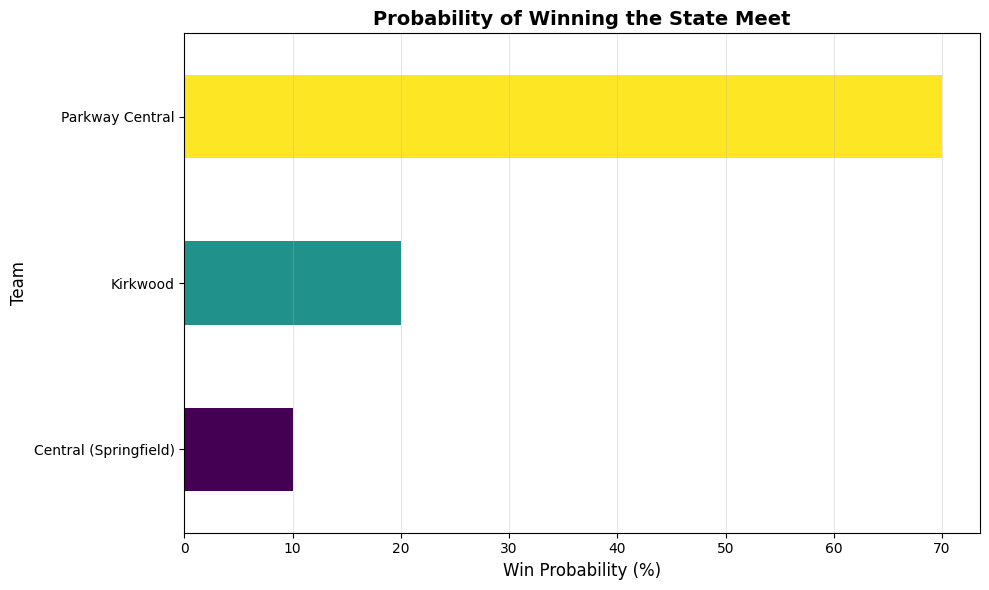

In [45]:
# Visualize win probabilities
plt.figure(figsize=(10, 6))
win_probs_sorted = win_probs.sort_values(ascending=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(win_probs_sorted)))
win_probs_sorted.plot(kind='barh', color=colors)
plt.title("Probability of Winning the State Meet", fontsize=14, fontweight='bold')
plt.xlabel("Win Probability (%)", fontsize=12)
plt.ylabel("Team", fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


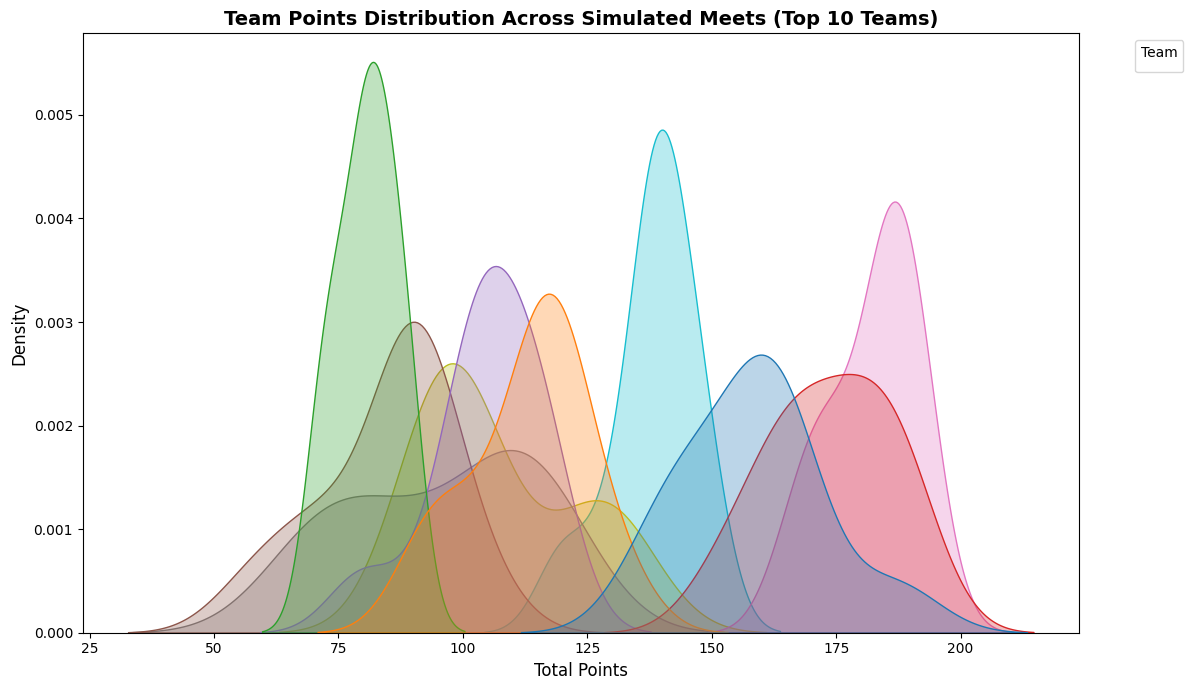

In [46]:
# Distribution of team scores (density plot)
plt.figure(figsize=(12, 7))

# Plot top 10 teams by mean score for clarity
top_teams = team_stats.head(10).index
df_top = df_scores[df_scores['team'].isin(top_teams)]

sns.kdeplot(data=df_top, x='points', hue='team', fill=True, alpha=0.3, palette='tab10')
plt.title("Team Points Distribution Across Simulated Meets (Top 10 Teams)", 
            fontsize=14, fontweight='bold')
plt.xlabel("Total Points", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/var/folders/jb/htz2wz0x3s93z17kl82cw22c0000gn/T/ipykernel_59580/4199871721.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_sorted, x='team', y='points', palette='Set2')


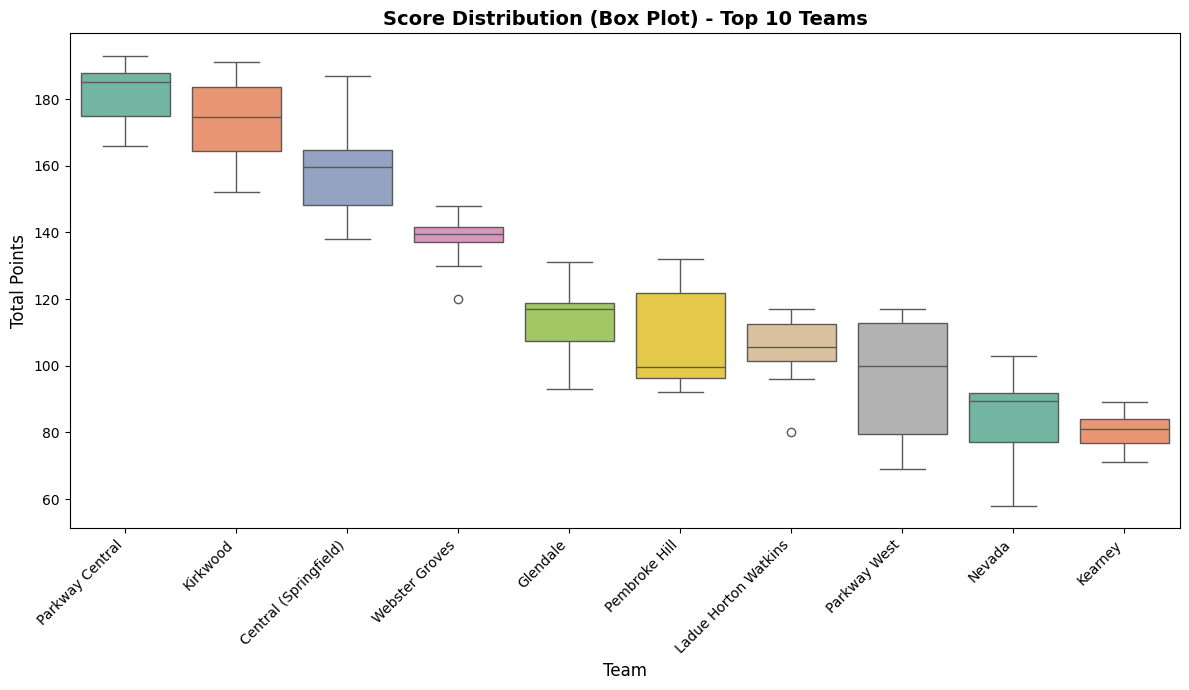

In [47]:
# Box plot showing score distributions for top teams
plt.figure(figsize=(12, 7))
top_teams_list = team_stats.head(10).index.tolist()
df_top_sorted = df_scores[df_scores['team'].isin(top_teams_list)].copy()

# Order by mean score
team_order = team_stats.head(10).index.tolist()
df_top_sorted['team'] = pd.Categorical(df_top_sorted['team'], categories=team_order, ordered=True)

sns.boxplot(data=df_top_sorted, x='team', y='points', palette='Set2')
plt.title("Score Distribution (Box Plot) - Top 10 Teams", fontsize=14, fontweight='bold')
plt.xlabel("Team", fontsize=12)
plt.ylabel("Total Points", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [49]:
# Summary table combining stats and win probabilities
summary = team_stats.merge(
    win_prob_df.set_index('team')[['win_probability_%', 'wins']],
    left_index=True,
    right_index=True,
    how='left'
).fillna(0)

summary = summary.sort_values('mean', ascending=False)
print("Complete Team Summary (sorted by average points):")
summary.head(15)


Complete Team Summary (sorted by average points):


,mean,std,min,max,median,q25,q75,win_probability_%,wins
team,,,,,,,,,
Parkway Central,182.2,8.8,166,193,185.0,175.0,187.8,70.0,7.0
Kirkwood,173.7,12.5,152,191,174.5,164.5,183.5,20.0,2.0
Central (Springfield),158.4,13.9,138,187,159.5,148.2,164.8,10.0,1.0
Webster Groves,138.2,8.3,120,148,139.5,137.0,141.8,0.0,0.0
Glendale,113.1,11.7,93,131,117.0,107.5,118.8,0.0,0.0
Pembroke Hill,107.5,15.3,92,132,99.5,96.2,121.8,0.0,0.0
Ladue Horton Watkins,104.6,11.0,80,117,105.5,101.5,112.5,0.0,0.0
Parkway West,96.0,18.7,69,117,100.0,79.5,112.8,0.0,0.0
Nevada,84.4,13.3,58,103,89.5,77.0,91.8,0.0,0.0


In [50]:
# Podium probabilities (top 3 finish)
team_totals = df_scores.groupby(['simulation_id', 'team'])['points'].sum().reset_index()

# Rank teams within each simulation
team_totals['rank'] = team_totals.groupby('simulation_id')['points'].rank(ascending=False, method='min')
team_totals['on_podium'] = (team_totals['rank'] <= 3).astype(int)

podium_probs = team_totals.groupby('team').agg({
    'on_podium': 'mean',
    'rank': 'mean'
}).round(3)
podium_probs.columns = ['podium_probability', 'avg_rank']
podium_probs = podium_probs.sort_values('podium_probability', ascending=False)

print("Podium Finish Probabilities:")
podium_probs.head(15)


Podium Finish Probabilities:


,podium_probability,avg_rank
team,,
Parkway Central,1.0,1.3
Kirkwood,1.0,2.0
Central (Springfield),0.9,2.8
Webster Groves,0.1,3.9
Belton,0.0,42.2
Platte County,0.0,17.7
Savannah,0.0,38.6
Rockwood Summit,0.0,34.3
Raytown,0.0,42.2


In [51]:
# Modified Monte Carlo function to collect individual swimmer results
def run_monte_carlo_with_results(df, assignments, relay_assignments=None, n_sims=500):
    """
    Run Monte Carlo simulations and collect both team scores AND individual swimmer results.
    Returns: (team_scores_all dict, df_results DataFrame)
    """
    team_scores_all = defaultdict(list)
    all_results = []
    
    for i in tqdm(range(n_sims), desc="Running Monte Carlo simulations with individual results"):
        full, team_scores = simulate_one_meet(df, assignments, relay_assignments)
        
        # Add simulation ID to results
        full['simulation_id'] = i
        all_results.append(full)
        
        # Store team scores
        for team, score in team_scores.items():
            team_scores_all[team].append(score)
    
    # Combine all individual results
    df_results = pd.concat(all_results, ignore_index=True)
    
    return team_scores_all, df_results


In [52]:
# Run Monte Carlo to get individual swimmer results
# Note: This will take some time (similar to the original run_monte_carlo)

team_scores_all_with_results, df_results = run_monte_carlo_with_results(result_df, assignments, relay_assignments, n_sims=10)

print(f"Collected results from {df_results['simulation_id'].nunique()} simulations")
print(f"Total swimmer-event results: {len(df_results)}")
print(f"Individual events: {len(df_results[df_results['is_relay']==False])}")
print(f"Relay events: {len(df_results[df_results['is_relay']==True])}")
print(f"\nColumns in df_results: {df_results.columns.tolist()}")
print(f"\nFirst few rows:")
df_results.head(10)


Running Monte Carlo simulations with individual results: 100%|██████████| 10/10 [00:00<00:00, 12.62it/s]

Collected results from 10 simulations
Total swimmer-event results: 2440
Individual events: 860
Relay events: 1580

Columns in df_results: ['name', 'team', 'event', 'time', 'state', 'is_relay', 'place', 'points', 'simulation_id']

First few rows:


,name,team,event,time,state,is_relay,place,points,simulation_id
0,Kolton Evans,Nevada,100 Backstroke,54.657339,Good,False,1,20,0
1,Kevin Wu,Ladue Horton Watkins,100 Backstroke,54.784889,Good,False,2,17,0
2,Jesse Myers,Central (Springfield),100 Backstroke,55.555121,Average,False,3,16,0
3,Evan Schmutz,Central (Springfield),100 Backstroke,56.389300,Average,False,4,15,0
4,Dane Tallent,Lutheran St. Charles,100 Backstroke,56.862315,Average,False,5,14,0
5,Samuel Wilkins,Glendale,100 Backstroke,57.294061,Average,False,6,13,0
6,Braeden Mallonee,Kearney,100 Backstroke,57.558881,Average,False,7,12,0
7,Hunter Morris,Christian Brothers College,100 Backstroke,58.281759,Bad,False,8,11,0
8,Kane Powell,Parkway North,100 Breaststroke,61.378263,Average,False,1,20,0
9,Liam O'Keefe,Pembroke Hill,100 Breaststroke,62.901503,Good,False,2,17,0


In [53]:
# show simple mean scores
{team: np.mean(scores) for team,scores in team_scores_all.items()}

{'Belton': 0.0,
 'Camdenton': 0.0,
 'Capital City': 0.0,
 'Carthage': 11.1,
 'Central (Cape Girardeau)': 0.0,
 'Central (Springfield)': 158.4,
 'Christian Brothers College': 45.1,
 'Clayton': 79.5,
 'Columbia Independent': 12.7,
 'De Smet Jesuit': 22.2,
 'Eureka': 48.1,
 'Farmington': 0.0,
 'Francis Howell North': 3.7,
 'Ft. Zumwalt North': 0.0,
 'Ft. Zumwalt South': 20.9,
 'Glendale': 113.1,
 'Grain Valley': 13.4,
 'Hannibal': 8.2,
 'Hillcrest': 0.0,
 'Holt': 14.9,
 'Jefferson City': 0.0,
 'John Burroughs': 42.1,
 'Kearney': 80.6,
 'Kirkwood': 173.7,
 'Ladue Horton Watkins': 104.6,
 'Lafayette (Wildwood)': 18.3,
 'Lebanon': 0.0,
 'Lincoln College Prep': 24.1,
 'Logan-Rogersville': 14.1,
 'Lutheran St. Charles': 25.7,
 'Marshall': 0.0,
 'McCluer North': 0.0,
 'Missouri Military Academy': 14.8,
 'Monett': 14.2,
 'Nevada': 84.4,
 'Notre Dame (Cape Girardeau)': 35.4,
 'Parkway Central': 182.2,
 'Parkway North': 33.2,
 'Parkway South': 59.9,
 'Parkway West': 96.0,
 'Pembroke Hill': 107.5,


/var/folders/jb/htz2wz0x3s93z17kl82cw22c0000gn/T/ipykernel_59580/3180621865.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({
/var/folders/jb/htz2wz0x3s93z17kl82cw22c0000gn/T/ipykernel_59580/3180621865.py:40: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from current font.
  plt.tight_layout()
/var/folders/jb/htz2wz0x3s93z17kl82cw22c0000gn/T/ipykernel_59580/3180621865.py:40: UserWarning: Glyph 129352 (\N{SECOND PLACE MEDAL}) missing from current font.
  plt.tight_layout()
/var/folders/jb/htz2wz0x3s93z17kl82cw22c0000gn/T/ipykernel_59580/3180621865.py:40: UserWarning: Glyph 129353 (\N{THIRD PLACE MEDAL}) missing from current font.
  plt.tight_layout()
/Use

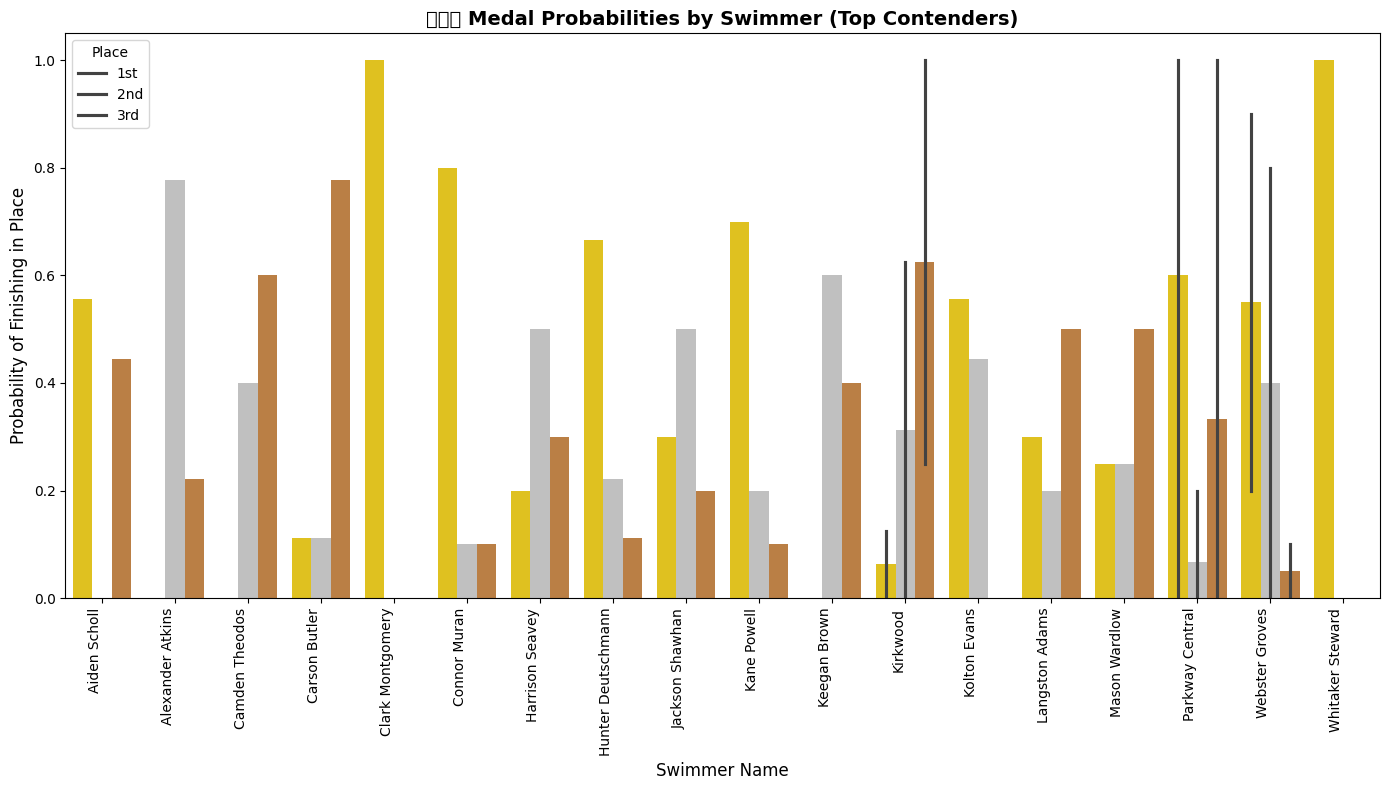

In [54]:
# Calculate medal probabilities (top 3 places)
# Note: 'name' is the column name from simulate_one_meet, not 'swimmer_name'
medal_probs = (
    df_results[df_results['place'] <= 3]
    .groupby(['name', 'event', 'place'])
    .size()
    .reset_index(name='count')
    .groupby(['name', 'event'])
    .apply(lambda x: pd.Series({
        'place_1': (x[x['place'] == 1]['count'].sum() / x['count'].sum()) if (x['place'] == 1).any() else 0,
        'place_2': (x[x['place'] == 2]['count'].sum() / x['count'].sum()) if (x['place'] == 2).any() else 0,
        'place_3': (x[x['place'] == 3]['count'].sum() / x['count'].sum()) if (x['place'] == 3).any() else 0,
        'total_podium': x['count'].sum() / df_results['simulation_id'].nunique()
    }))
    .reset_index()
)

# Melt to long format for easier plotting
medal_probs_long = medal_probs.melt(
    id_vars=['name', 'event'],
    value_vars=['place_1', 'place_2', 'place_3'],
    var_name='place',
    value_name='probability'
)
medal_probs_long['place'] = medal_probs_long['place'].str.replace('place_', '').astype(int)

# Filter to swimmers with meaningful podium probabilities (at least 1% in any simulation)
top_medal_contenders = medal_probs[medal_probs['total_podium'] > 0.01].sort_values('total_podium', ascending=False)
top_names = top_medal_contenders['name'].head(20).unique()

medal_probs_filtered = medal_probs_long[medal_probs_long['name'].isin(top_names)]

plt.figure(figsize=(14, 8))
sns.barplot(data=medal_probs_filtered, x='name', y='probability', hue='place', palette={1: 'gold', 2: 'silver', 3: '#CD7F32'})
plt.title("🥇🥈🥉 Medal Probabilities by Swimmer (Top Contenders)", fontsize=14, fontweight='bold')
plt.xticks(rotation=90, ha='right')
plt.ylabel("Probability of Finishing in Place", fontsize=12)
plt.xlabel("Swimmer Name", fontsize=12)
plt.legend(title='Place', labels=['1st', '2nd', '3rd'])
plt.tight_layout()
plt.show()

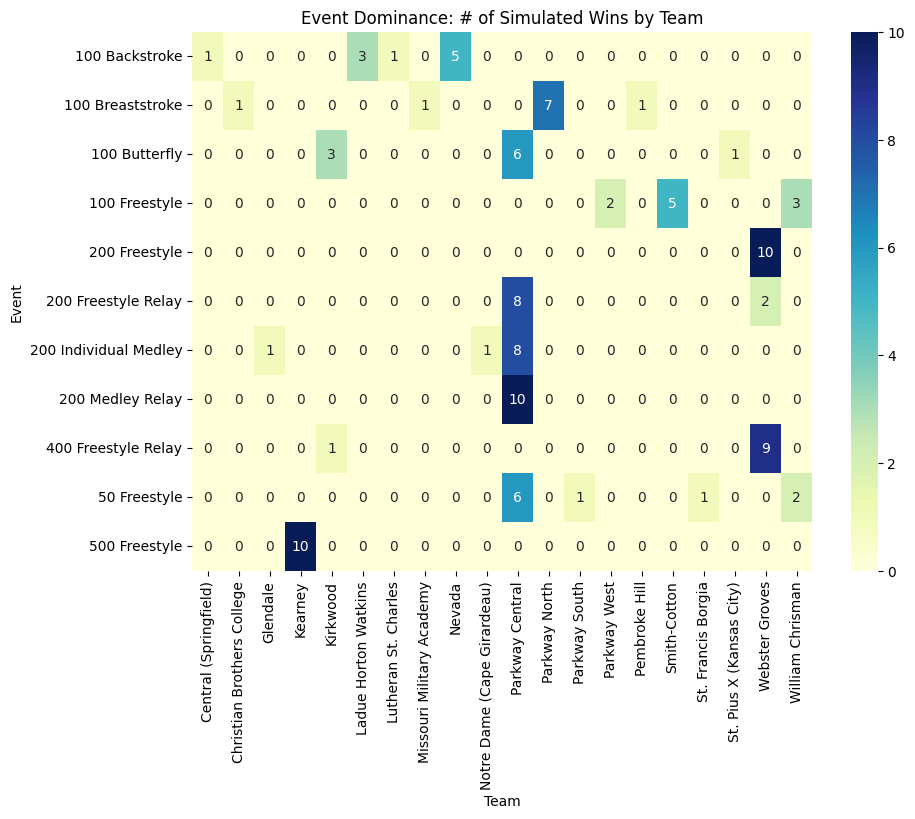

In [55]:
event_strength = (
    df_results[df_results['place'] == 1]
    .groupby(['event', 'team'])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(10,7))
sns.heatmap(event_strength, cmap="YlGnBu", annot=True, fmt='d')
plt.title("Event Dominance: # of Simulated Wins by Team")
plt.xlabel("Team")
plt.ylabel("Event")
plt.show()

## Relay Probabilities Analysis

Relays are scored with DOUBLE points, so they have a significant impact on team scores. Let's analyze relay win probabilities and medal probabilities.


In [56]:
# Relay win probabilities (which team wins each relay event most often)
# Check if is_relay column exists, if not infer from event names
if 'is_relay' in df_results.columns:
    relay_results = df_results[df_results['is_relay'] == True].copy()
else:
    # Infer relays from event names containing "Relay"
    print("Note: 'is_relay' column not found. Inferring relays from event names...")
    df_results['is_relay'] = df_results['event'].str.contains('Relay', case=False, na=False)
    relay_results = df_results[df_results['is_relay'] == True].copy()

if len(relay_results) == 0:
    print("⚠️ No relay results found. Please re-run the Monte Carlo simulation after updating the code.")
    print("Relay events should now be included in result_df with is_relay=True")
else:
    relay_win_probs = (
        relay_results[relay_results['place'] == 1]
        .groupby(['event', 'team'])
        .size()
        .reset_index(name='wins')
        .groupby('event')
        .apply(lambda x: x.assign(win_probability=x['wins'] / x['wins'].sum() * 100))
        .reset_index(drop=True)
        .sort_values(['event', 'win_probability'], ascending=[True, False])
    )

    print("Relay Win Probabilities by Event and Team:")
    print(f"Total simulations: {df_results['simulation_id'].nunique()}")
    relay_win_probs.head(20)


Relay Win Probabilities by Event and Team:
Total simulations: 10


/var/folders/jb/htz2wz0x3s93z17kl82cw22c0000gn/T/ipykernel_59580/3678600167.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(win_probability=x['wins'] / x['wins'].sum() * 100))


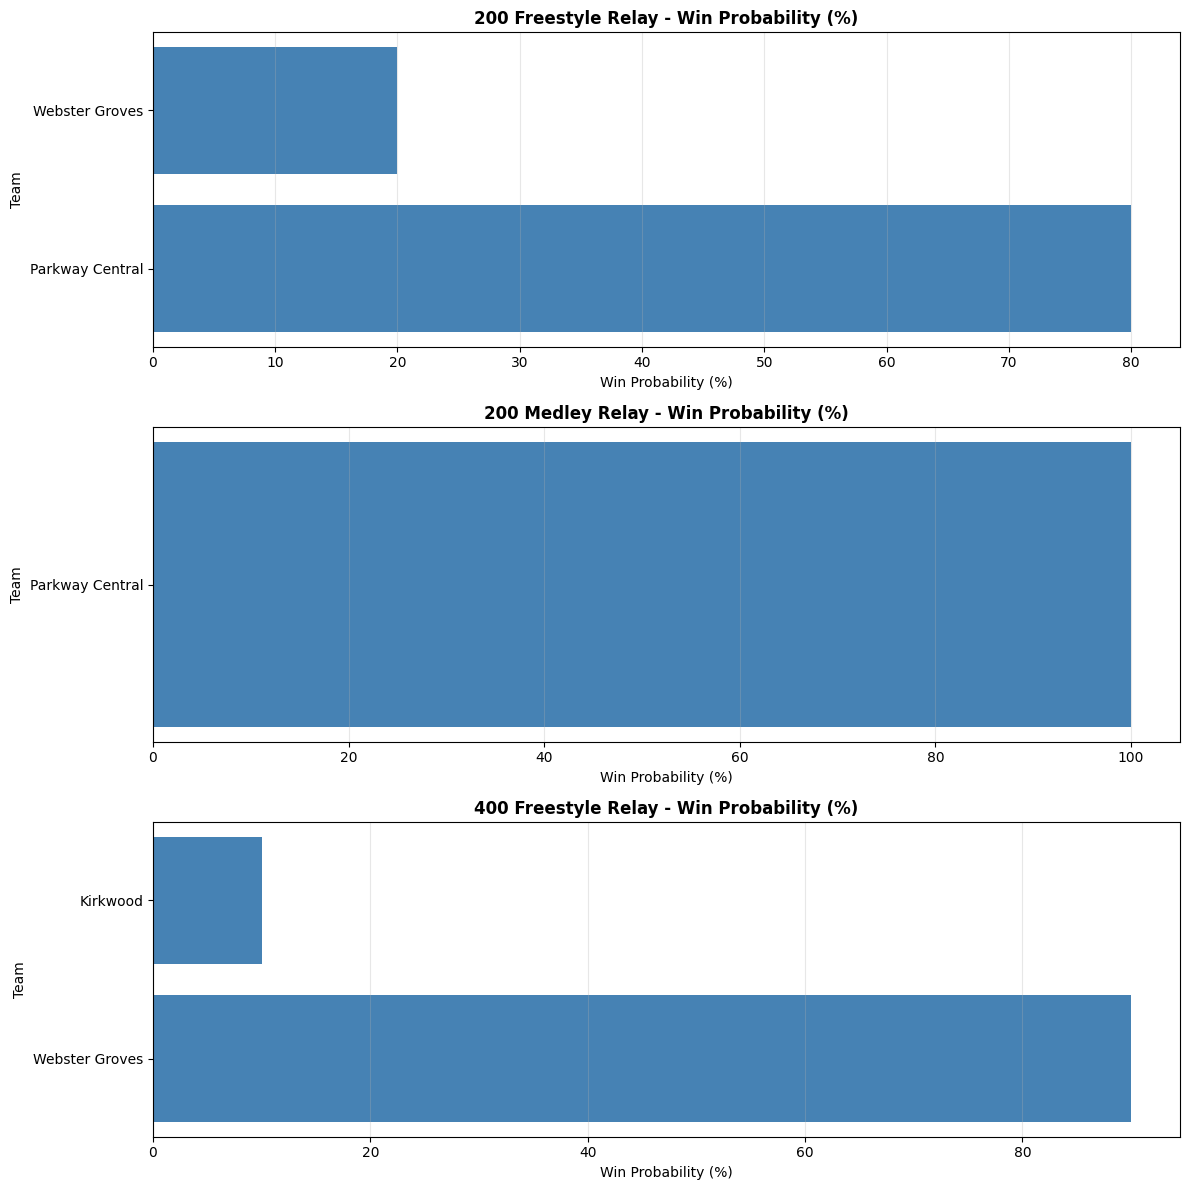

In [57]:
# Visualize relay win probabilities
relay_events = relay_results['event'].unique()
fig, axes = plt.subplots(len(relay_events), 1, figsize=(12, 4*len(relay_events)))
if len(relay_events) == 1:
    axes = [axes]

for idx, event in enumerate(relay_events):
    event_data = relay_win_probs[relay_win_probs['event'] == event].head(10)
    if len(event_data) > 0:
        axes[idx].barh(event_data['team'], event_data['win_probability'], color='steelblue')
        axes[idx].set_title(f"{event} - Win Probability (%)", fontsize=12, fontweight='bold')
        axes[idx].set_xlabel("Win Probability (%)", fontsize=10)
        axes[idx].set_ylabel("Team", fontsize=10)
        axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [58]:
# Relay medal probabilities (top 3 places)
if len(relay_results) > 0:
    relay_medal_probs = (
        relay_results[relay_results['place'] <= 3]
        .groupby(['event', 'team', 'place'])
        .size()
        .reset_index(name='count')
        .groupby(['event', 'team'])
        .apply(lambda x: pd.Series({
            'place_1': (x[x['place'] == 1]['count'].sum() / x['count'].sum()) if (x['place'] == 1).any() else 0,
            'place_2': (x[x['place'] == 2]['count'].sum() / x['count'].sum()) if (x['place'] == 2).any() else 0,
            'place_3': (x[x['place'] == 3]['count'].sum() / x['count'].sum()) if (x['place'] == 3).any() else 0,
            'total_podium': x['count'].sum() / df_results['simulation_id'].nunique()
        }))
        .reset_index()
    )

    # Melt to long format
    relay_medal_probs_long = relay_medal_probs.melt(
        id_vars=['event', 'team'],
        value_vars=['place_1', 'place_2', 'place_3'],
        var_name='place',
        value_name='probability'
    )
    relay_medal_probs_long['place'] = relay_medal_probs_long['place'].str.replace('place_', '').astype(int)

    # Filter to top contenders (at least 5% podium probability)
    top_relay_contenders = relay_medal_probs[relay_medal_probs['total_podium'] > 0.05].sort_values('total_podium', ascending=False)

    print("🏊 Relay Medal Probabilities (Top Contenders):")
    print(f"Showing teams with at least 5% podium probability")
    top_relay_contenders.head(20)
else:
    print("⚠️ No relay results found. Please re-run the Monte Carlo simulation.")


🏊 Relay Medal Probabilities (Top Contenders):
Showing teams with at least 5% podium probability


/var/folders/jb/htz2wz0x3s93z17kl82cw22c0000gn/T/ipykernel_59580/3717949333.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


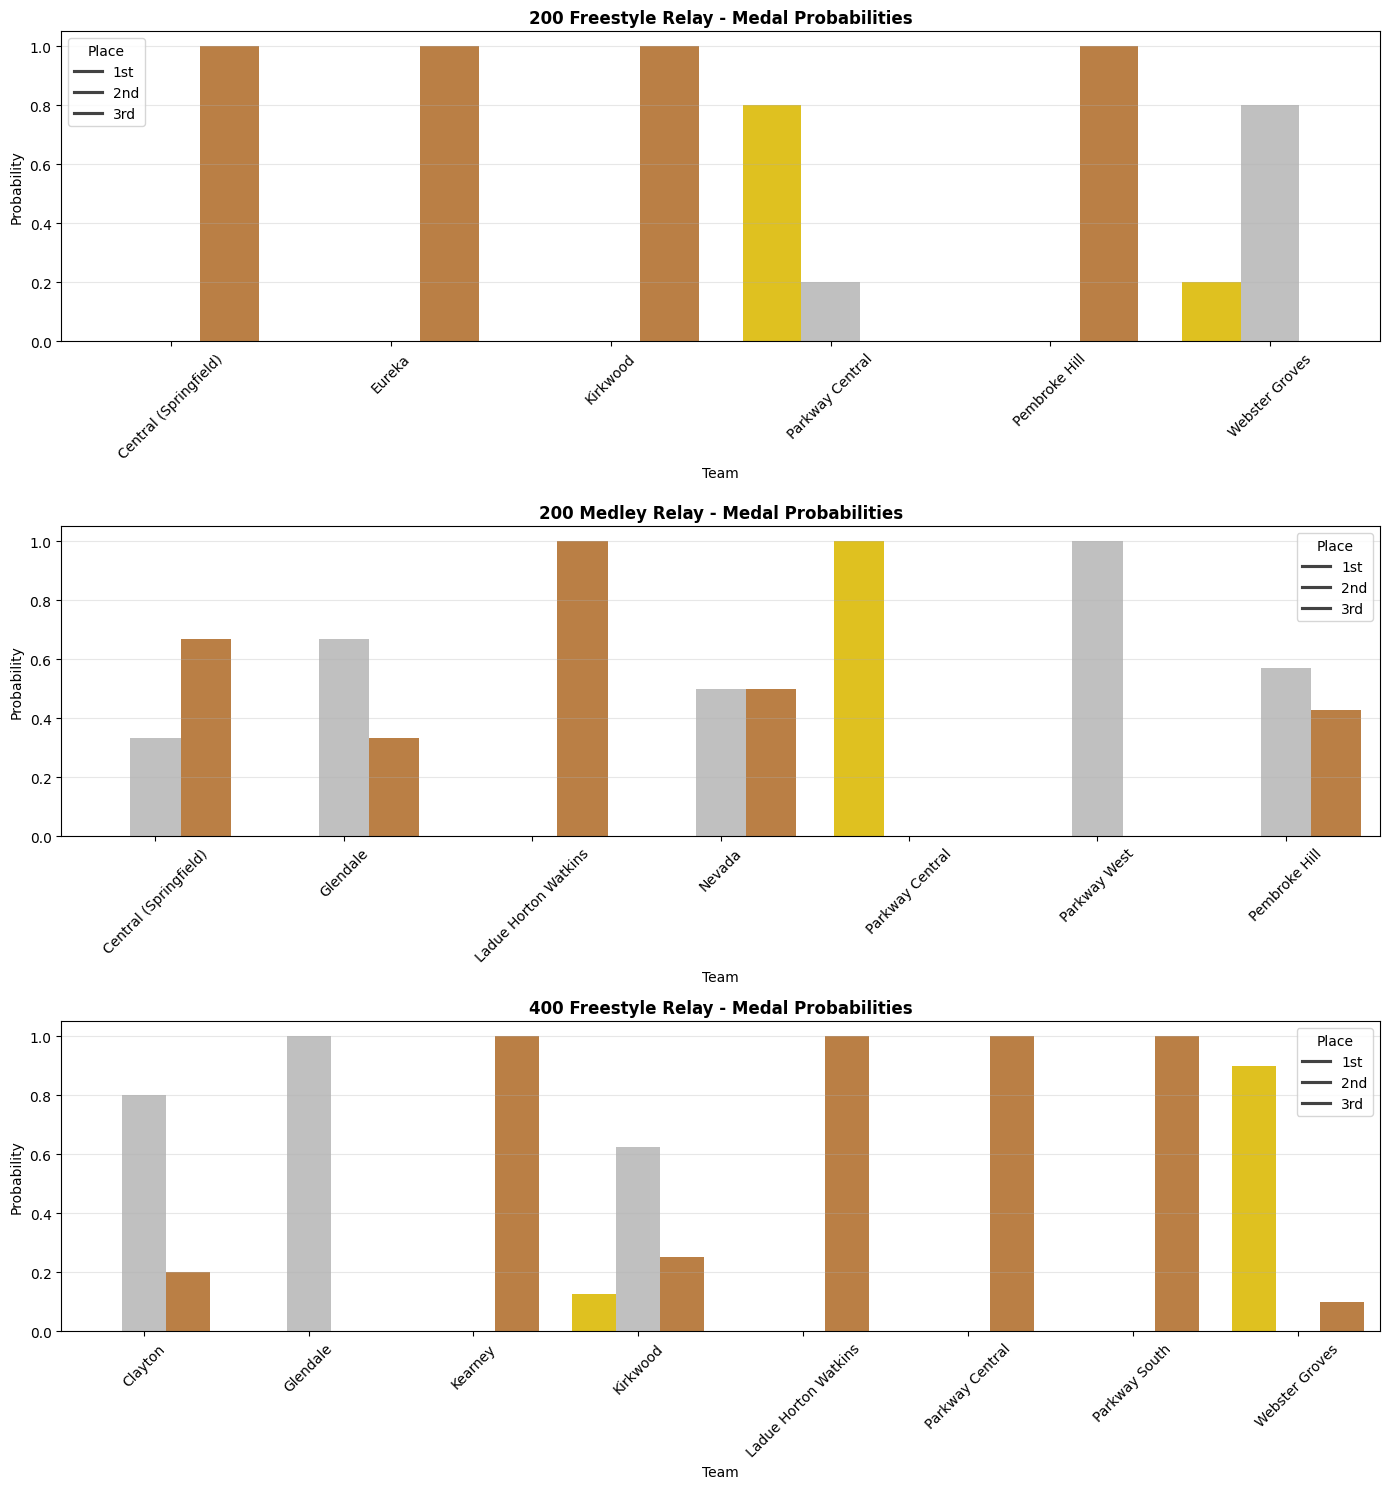

In [59]:
# Visualize relay medal probabilities
if len(relay_results) > 0 and 'relay_medal_probs_long' in locals() and 'top_relay_contenders' in locals():
    relay_events = relay_results['event'].unique()
    if len(relay_events) > 0:
        fig, axes = plt.subplots(len(relay_events), 1, figsize=(14, 5*len(relay_events)))
        if len(relay_events) == 1:
            axes = [axes]

        for idx, event in enumerate(relay_events):
            event_contenders = top_relay_contenders[top_relay_contenders['event'] == event]['team'].head(10)
            if len(event_contenders) > 0:
                event_data = relay_medal_probs_long[
                    (relay_medal_probs_long['event'] == event) & 
                    (relay_medal_probs_long['team'].isin(event_contenders))
                ]
                
                if len(event_data) > 0:
                    sns.barplot(data=event_data, x='team', y='probability', hue='place', 
                               palette={1: 'gold', 2: 'silver', 3: '#CD7F32'}, ax=axes[idx])
                    axes[idx].set_title(f"{event} - Medal Probabilities", fontsize=12, fontweight='bold')
                    axes[idx].set_xlabel("Team", fontsize=10)
                    axes[idx].set_ylabel("Probability", fontsize=10)
                    axes[idx].tick_params(axis='x', rotation=45)
                    axes[idx].legend(title='Place', labels=['1st', '2nd', '3rd'])
                    axes[idx].grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No relay events found to visualize")
else:
    print("⚠️ No relay medal data available. Please re-run the Monte Carlo simulation.")


In [60]:
individual_points = (
    df_results[df_results['is_relay'] == False]
    .groupby(['simulation_id', 'team'])['points']
    .sum()
    .reset_index()
    .rename(columns={'points': 'individual_points'})
)

# Relay points by team
relay_points = (
    relay_results.groupby(['simulation_id', 'team'])['points']
    .sum()
    .reset_index()
    .rename(columns={'points': 'relay_points'})
)

# Combine individual and relay points
total_points = individual_points.merge(
    relay_points,
    on=['simulation_id', 'team'],
    how='outer'
).fillna(0)

total_points['total_points'] = total_points['individual_points'] + total_points['relay_points']

# Summary statistics by team
team_breakdown = (
    total_points.groupby('team')
    .agg({
        'individual_points': ['mean', 'std'],
        'relay_points': ['mean', 'std'],
        'total_points': ['mean', 'std', 'min', 'max']
    })
    .round(1)
)

# Flatten column names
team_breakdown.columns = [
    'avg_individual_pts', 'std_individual_pts',
    'avg_relay_pts', 'std_relay_pts',
    'avg_total_pts', 'std_total_pts', 'min_total_pts', 'max_total_pts'
]

team_breakdown = team_breakdown.sort_values('avg_total_pts', ascending=False)

In [62]:
print("Team Points Breakdown: Individual Events + Relays")
print("\nTop 15 teams by average total points:")
team_breakdown.head(15)

Team Points Breakdown: Individual Events + Relays

Top 15 teams by average total points:


,avg_individual_pts,std_individual_pts,avg_relay_pts,std_relay_pts,avg_total_pts,std_total_pts,min_total_pts,max_total_pts
team,,,,,,,,
Parkway Central,76.0,5.2,104.6,5.3,180.6,7.3,169.0,188.0
Kirkwood,94.4,5.2,82.0,11.6,176.4,10.3,159.0,193.0
Central (Springfield),82.2,4.5,66.8,8.1,149.0,6.9,134.0,159.0
Webster Groves,49.9,1.7,87.8,8.1,137.7,8.1,120.0,148.0
Ladue Horton Watkins,43.1,2.2,66.4,7.2,109.5,6.7,101.0,124.0
Glendale,57.7,3.5,51.8,12.9,109.5,12.4,92.0,129.0
Pembroke Hill,33.5,4.7,71.0,9.1,104.5,9.0,85.0,113.0
Clayton,28.0,2.2,63.0,9.9,91.0,10.7,76.0,108.0
Parkway West,52.5,3.4,37.2,13.6,89.7,14.2,72.0,117.0


In [63]:
team_breakdown['relay_contribution_%'] = (
    (team_breakdown['avg_relay_pts'] / team_breakdown['avg_total_pts'] * 100).round(1)
)
print("\nRelay contribution as percentage of total points:")
team_breakdown[['avg_individual_pts', 'avg_relay_pts', 'avg_total_pts', 'relay_contribution_%']].head(15)


Relay contribution as percentage of total points:


,avg_individual_pts,avg_relay_pts,avg_total_pts,relay_contribution_%
team,,,,
Parkway Central,76.0,104.6,180.6,57.9
Kirkwood,94.4,82.0,176.4,46.5
Central (Springfield),82.2,66.8,149.0,44.8
Webster Groves,49.9,87.8,137.7,63.8
Ladue Horton Watkins,43.1,66.4,109.5,60.6
Glendale,57.7,51.8,109.5,47.3
Pembroke Hill,33.5,71.0,104.5,67.9
Clayton,28.0,63.0,91.0,69.2
Parkway West,52.5,37.2,89.7,41.5
